https://www.kaggle.com/datasets/elliotx1000/french-railway-monthly-tgv-regularity

https://ressources.data.sncf.com/explore/dataset/regularite-mensuelle-tgv-aqst/information/?sort=date&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJzcGxpbmUiLCJmdW5jIjoiQVZHIiwieUF4aXMiOiJwcmN0X2NhdXNlX2V4dGVybmUiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1TZXQxIn1dLCJ4QXhpcyI6ImRhdGUiLCJtYXhwb2ludHMiOiIiLCJ0aW1lc2NhbGUiOiJtb250aCIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJzZXJ2aWNlIiwiY29uZmlnIjp7ImRhdGFzZXQiOiJyZWd1bGFyaXRlLW1lbnN1ZWxsZS10Z3YtYXFzdCIsIm9wdGlvbnMiOnsic29ydCI6ImRhdGUifX19XSwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZSwidGltZXNjYWxlIjoiIn0%3D
Go to "Export", then select the CSV file.

In [55]:
import platform
from pathlib import Path

import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


## Introduction

This project aims to predict different targets about SNCF trains delayed. We will first predict the number of trains delayed, based on the month, departure station, arrival station (more proposed to the company), and then we will predict the average delay of trains by month (more for customers).

## Initialize, treat and clean the dataset

We are first going to load the data file and clean the columns that will never be useful (particularly, the commentaries columns).

In [3]:
DATA = Path("data")
assert DATA.exists()

label_encoder = LabelEncoder()

# Load the CSV file
sncf_data_primal = "regularite-mensuelle-tgv-aqst.csv"
df = pd.read_csv(DATA / sncf_data_primal, sep=';', low_memory=False)

# Create a new CSV file without the columns containing "Commentaire" (these columns do not interest us for our model)
sncf_data = df.loc[:, ~df.columns.str.contains("Commentaire")].copy()

# Print the columns left
print(sncf_data.columns)

# Translate text values in certain columns into values (0-1 or a list of index)
sncf_data['Date'] = sncf_data['Date'].str.split("-").str[1]
sncf_data['Gare de départ'] = label_encoder.fit_transform(sncf_data['Gare de départ'])
sncf_data["Gare d'arrivée"] = label_encoder.fit_transform(sncf_data["Gare d'arrivée"])
sncf_data["Service"] = sncf_data["Service"].map({'National': 0, 'International': 1})


# Dictionnary which contains the train station's name with its index
correspondance_indices = pd.DataFrame({
        "Indice": range(len(label_encoder.classes_)),
        "Gare": label_encoder.classes_
})

# Save the new files to the data folder
correspondance_indices.to_csv(DATA / 'correspondance_gare.csv', index=False)
sncf_data.to_csv(DATA / "sncf_data.csv",index=False)

Index(['Date', 'Service', 'Gare de départ', 'Gare d'arrivée',
       'Durée moyenne du trajet', 'Nombre de circulations prévues',
       'Nombre de trains annulés', 'Nombre de trains en retard au départ',
       'Retard moyen des trains en retard au départ',
       'Retard moyen de tous les trains au départ',
       'Nombre de trains en retard à l'arrivée',
       'Retard moyen des trains en retard à l'arrivée',
       'Retard moyen de tous les trains à l'arrivée',
       'Nombre trains en retard > 15min',
       'Retard moyen trains en retard > 15 (si liaison concurrencée par vol)',
       'Nombre trains en retard > 30min', 'Nombre trains en retard > 60min',
       'Prct retard pour causes externes',
       'Prct retard pour cause infrastructure',
       'Prct retard pour cause gestion trafic',
       'Prct retard pour cause matériel roulant',
       'Prct retard pour cause gestion en gare et réutilisation de matériel',
       'Prct retard pour cause prise en compte voyageurs (affluen

We are going to focus on the prediction of 1 column, then we will compare to other columns predictions.

We will train our model on 5 different columns : 
    
    - Date
    - Departure Station
    - Arrival Station
    - Average trip duration
    - Number of planned circulations
These columns will predict the target "Number of trains delayed on arrival".

Later, we will also look at the results of the predictions for "Number of trains delayed on departure", "Average delay of all trains on departure", and "Average delay of all trains on arrival".

Let's initialize these values :

In [76]:
X=sncf_data[["Date","Gare de départ","Gare d'arrivée","Durée moyenne du trajet","Nombre de circulations prévues"]]
Y_nb_retard_arrivee=sncf_data["Nombre de trains en retard à l'arrivée"]

First, let's learn something on our data. For example, we can study columns and look which ones are the most correlated to our target :

In [21]:
def corr_matrix(Y_name):
    sncf_corr = sncf_data.corr()
    target_correlation = sncf_corr[Y_name]
    top_5_most_correlated = target_correlation.abs().sort_values(ascending=False)[1:6]
    top_5_less_correlated = target_correlation.abs().sort_values(ascending=True)[1:6]

    print("The 5 columns most correlated (negatively or positively) : ")
    print(top_5_most_correlated,"\n")

    print("The 5 columns less correlated (negatively or positively) : ")
    print(top_5_less_correlated)

corr_matrix("Nombre de trains en retard à l'arrivée")

The 5 columns most correlated (negatively or positively) : 
Nombre trains en retard > 15min         0.890164
Nombre trains en retard > 30min         0.813341
Nombre de circulations prévues          0.754078
Nombre trains en retard > 60min         0.688425
Nombre de trains en retard au départ    0.651414
Name: Nombre de trains en retard à l'arrivée, dtype: float64 

The 5 columns less correlated (negatively or positively) : 
Prct retard pour cause infrastructure                                                          0.004338
Prct retard pour cause matériel roulant                                                        0.010033
Retard moyen trains en retard > 15 (si liaison concurrencée par vol)                           0.022186
Prct retard pour causes externes                                                               0.031516
Prct retard pour cause prise en compte voyageurs (affluence, gestions PSH, correspondances)    0.046560
Name: Nombre de trains en retard à l'arrivée, dtype:

Obviously, the trains that are delayed on departure are more likely to be late on arrival. Also, the more we have trains, the more it is likely to have trains delayed. 

We can also see that none of our columns selected to predict the target are on the less correlated. The need to use PCA is less likely, but we will verify it properly later.

## Which model is the best

There are different models that can be used to do a regression. Also, the "No Free Lunch" Theorem confirms that there is not one model that will be better whatever the case is. As a result, we have to test different models and compare their score to see which one is the best. We will test :

    - Linear Regression
    - Polynomial Regression
    - Ridge Regression
    - Lasso Regression
    - Random Forest
    - Gradient Boosting
  
Let's compare their MSE to see which one is the most optimal for this data structure :

In [23]:
models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": Pipeline([
        ('poly', PolynomialFeatures(degree=5)),
        ('linear', LinearRegression())
    ]),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor()
}

def find_best_model(X,Y):
    # Compare with the cross-validation
    scoring = 'neg_mean_squared_error'  # Use MSE to evaluate the models
    results = {}

    for name, model in models.items():
        scores = cross_val_score(model, X, Y, scoring=scoring, cv=5)
        results[name] = np.mean(scores)  # Mean of the MSE (negative)

    for name, score in results.items():
        print(name,": MSE = ",-score)

find_best_model(X,Y_nb_retard_arrivee)


Linear Regression : MSE =  414.0426752338132
Polynomial Regression : MSE =  8619.645014953223
Ridge Regression : MSE =  414.04263132111635
Lasso Regression : MSE =  414.0134140914414
Random Forest : MSE =  309.7435379589475
Gradient Boosting : MSE =  315.62662133728446


As we can see, the "Random Forest" model seems to be the best one, at least the one with the smallest MSE. We will keep this model for the rest of the project.

## Train the model

Let's train the model on our dataset, and look at the MSE and R² score. We can also draw a graph to compare the original data of the test set with the prediction :

Mean Squared Error: 257.14849240415384
R-squared Score: 0.7314749777437356
Average number of circulations :  266.97590603353075


[]

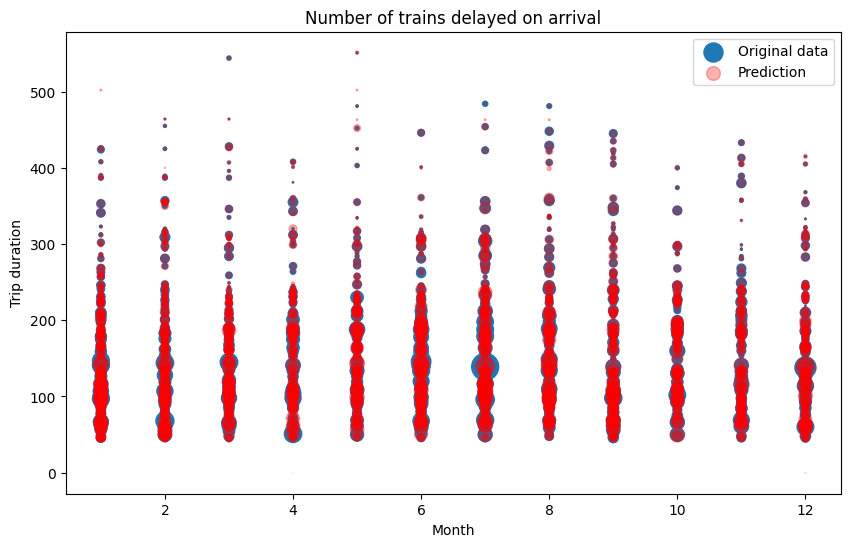

In [ ]:
def train_model(modeltype, X, Y):
    model = models[modeltype] # The model changes with the target's most efficient model, specified in argument
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test,y_pred) # Look at the MSE score to evaluate our model
    print("Mean Squared Error:", mse)
    r2 = r2_score(y_test,y_pred) # Look also at the R²-score to double-check
    print("R-squared Score:", r2)

    return model, X_train, X_test, y_train, y_test, y_pred

model, X_train, X_test, y_train, y_test, y_pred = train_model("Random Forest",X,Y_nb_retard_arrivee)

print("Average number of circulations : ",sncf_data["Nombre de circulations prévues"].mean()) # Helps to evaluate if our
                                                                                            # model has a good MSE score
plt.figure(figsize=(10, 6))
X_test.iloc[:, 0] = X_test.iloc[:, 0].astype(int)
X_test.iloc[:, 3] = X_test.iloc[:, 3].astype(int)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 3], y_test, label='Original data')
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 3], y_pred, color='red', alpha=.3,label='Prediction')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Trip duration")
plt.title("Number of trains delayed on arrival")
plt.plot() # Plot our model prediction with the original data

The MSE is quite good, because the mean of the circulations planned per month is around 267 and we can see we have an average error of ($\sqrt{MSE}\approx$)16 trains, which is less than 6%.

We also have around 0.73 of R²-score, which is also a good score.

We can also look at the plot result :

To give an explanation, we have Months on X axis (1 is January, 12 is December...), the trip duration on Y axis, and the biggest the number of trains delayed on arrival is, the biggest the plot is represented. For example, we can see there is a lot of trains delayed on arrival with a trip of around 150 minutes on July.

We can also remark that our model predicts quite well the unusual values, for example the values around 500 minutes of trip duration on March and July.

## Cross-validation test

Let's see if the cross-validation score gives us a better score :

In [ ]:
def crossval(X_train, y_train):
    SCORINGS = "r2"
    cvs = model_selection.cross_val_score(estimator=model, X=X_train, cv=5, y=y_train, scoring=SCORINGS)
    print("Cross-Validation Scores (R²):", cvs)
    print("Mean : ",cvs.mean())
    return cvs
cvs = crossval(X_train,y_train)

Cross-Validation Scores (R²): [0.74629884 0.73915873 0.72626964 0.73309533 0.74943476]
Mean :  0.7388514596490486


We can see that the mean of the R²-scores gives us around the same R²-score as the previous one, so we don't have to use the cross-validation score to get our model better.

We can still represent the R²-scores on a plot with the standard deviation :

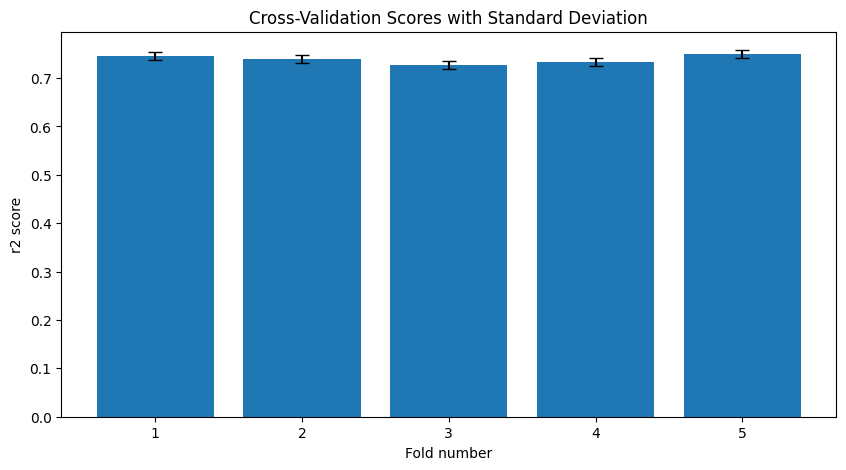

In [ ]:
def plot_crossval(cvs):
    std_dev = np.std(cvs)
    plt.figure(figsize=(10, 5))
    plt.bar(range(1, len(cvs) + 1), cvs, yerr=std_dev, capsize=5)
    plt.xlabel("Fold number")
    plt.ylabel("r2 score")
    plt.title("Cross-Validation Scores with Standard Deviation")
    plt.show()
plot_crossval(cvs)

## GridSearchCV

Let's do a GridSearchCV evaluation to determine the best hyperparameters for our model. We will by the way also test if PCA is useful or not : if PCA__n_components returns 5, then it will mean that all of our 5 columns are useful, so no need to use PCA to reduce the dimensions.

The other values will determine the best hyperparameters for our RandomForestRegressor model :

In [61]:
param_grid = {
    "pca__n_components": [1,2,3,4,5],
    "regressor__n_estimators": [50, 100, 200],
    "regressor__max_depth": [None, 10, 20]
}

In [62]:


pipeline = Pipeline([
    ('pca', PCA()),
    ('regressor', RandomForestRegressor())
])


In [63]:
grid_search = GridSearchCV(estimator=pipeline, 
    param_grid=param_grid, scoring="r2", cv=5)
grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

Meilleur paramètre :  {'regressor__max_depth': 20, 'regressor__n_estimators': 200}
MSE sur l'ensemble de test : 257.55829744295073
R² sur l'ensemble de test : 0.7310470424829265


[]

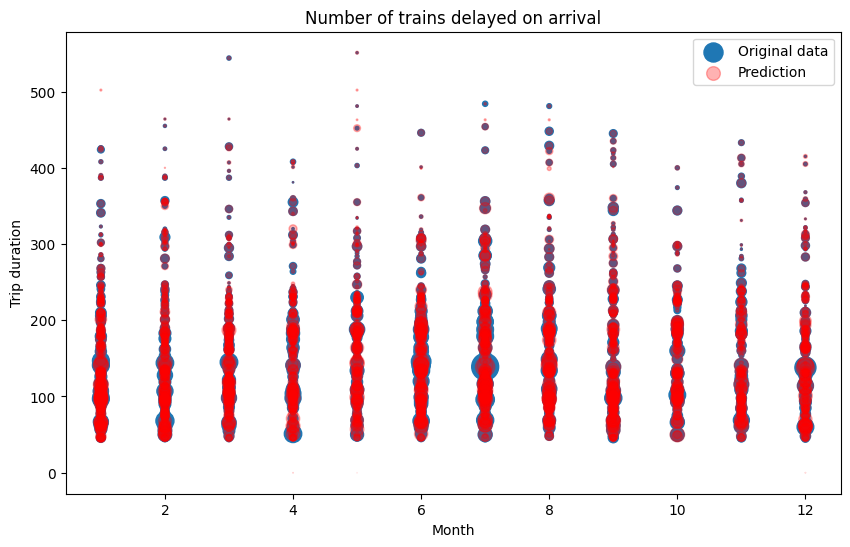

In [54]:
best_model_gs = grid_search.best_estimator_
y_pred = best_model_gs.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Meilleur paramètre : ", grid_search.best_params_)
print("MSE sur l'ensemble de test :", mse)
print("R² sur l'ensemble de test :", r2)

plt.figure(figsize=(10, 6))
X_test.iloc[:, 0] = X_test.iloc[:, 0].astype(int)
X_test.iloc[:, 3] = X_test.iloc[:, 3].astype(int)
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 3], y_test, label='Original data')
plt.scatter(X_test.iloc[:, 0], X_test.iloc[:, 3], y_pred, color='red', alpha=.3,label='Prediction')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Trip duration")
plt.title("Number of trains delayed on arrival")
plt.plot() # Plot our model prediction with the original data

In [ ]:
# Save the best parameters and the best score
with open("data/meilleur_resultat.txt", "w") as f:
    f.write(f"Meilleurs paramètres : {grid_search.best_params_}\n")
    f.write(f"Meilleur score R² : {grid_search.best_score_}\n")


In [ ]:
import ast  # To convert the parameter string into a Python dictionnary

# Open the file
with open("data/meilleur_resultat.txt", "r") as f:
    lines = f.readlines()

# Initialize the variables for the results
best_params = None
best_score = None

# Go throught the lines to extract the information
for line in lines:
    if "Meilleurs paramètres" in line:
        best_params_str = line.split(":", 1)[1].strip()  # Get the part after ":"
        best_params = ast.literal_eval(best_params_str)  # Convert into a dictionnary
        # Extract the parameters of the regressor
        regressor_params = {
            "max_depth": best_params['regressor__max_depth'],
            "n_estimators": best_params['regressor__n_estimators']
        }
        grid_search.best_estimator_ = regressor_params
    elif "Meilleur score R²" in line:
        best_score = float(line.split(":", 1)[1].strip())  # Get the part after ":"


## The other targets

Now that we made different tests and observations on the main target "Number of trains delayed on arrival", let's see if we can predict with a score as good as before the other targets.

We can start with another similar target, "Number of trains delayed on departure". We will re execute the same process :

- Find the best model
- Train on the best model
- Display the original vs prediction graph
- Look at the cross-validation score and display the graph

We will skip the GridSearchCV for these new targets.

### Target #2

In [122]:
Y_nb_retard_depart=sncf_data["Nombre de trains en retard au départ"]
find_best_model(X,Y_nb_retard_depart) # First step : Find the best model for this new target

Linear Regression : MSE =  5400.3295629128315
Polynomial Regression : MSE =  6082.9441489513365
Ridge Regression : MSE =  5400.329532050078
Lasso Regression : MSE =  5400.349289162777
Random Forest : MSE =  4183.274070263903
Gradient Boosting : MSE =  3814.692403372047


Mean Squared Error: 2567.697061850643
R-squared Score: 0.6648244921594115


/home/felix/.local/lib/python3.10/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


[]

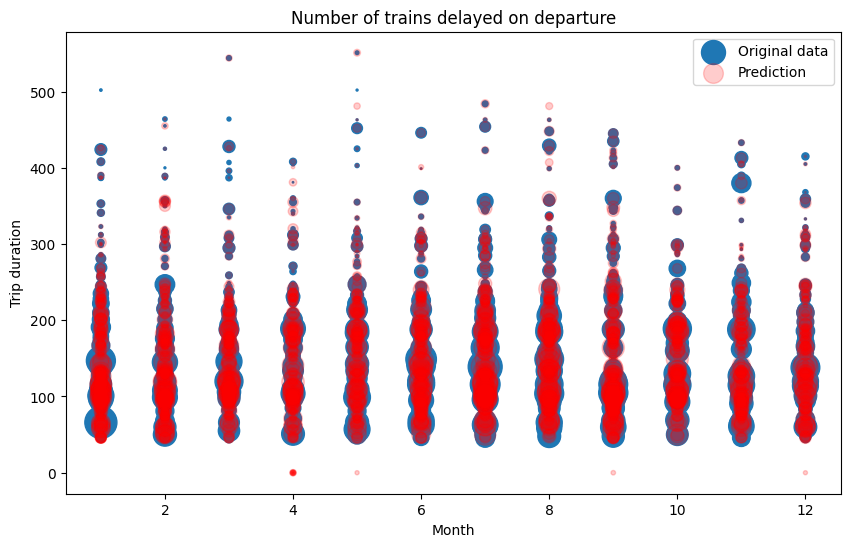

In [ ]:
model2, X_train2, X_test2, y_train2, y_test2, y_pred2 = train_model("Gradient Boosting",X,Y_nb_retard_depart) # Now that we found the best model, train the model with Gradient Boosting
plt.figure(figsize=(10, 6))
X_test2.iloc[:, 0] = X_test2.iloc[:, 0].astype(int)
X_test2.iloc[:, 3] = X_test2.iloc[:, 3].astype(int)
plt.scatter(X_test2.iloc[:, 0], X_test2.iloc[:, 3], y_test2, label='Original data')
plt.scatter(X_test2.iloc[:, 0], X_test2.iloc[:, 3], y_pred2, color='red', alpha=.2,label='Prediction')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Trip duration")
plt.title("Number of trains delayed on departure")
plt.plot() # Plot the graph with the original data and prediction, and study the MSE / R²-score


We can see here that the MSE score is way higher than before, which means our model could be unprecise. However, we still have a 0.66 R²-score, which is quite good. We can see on the graph that the model represents quite well the big values, but is a bit less performant on unusual values, unlike the last prediction.

Let's look at the cross-validation score to see if we can get a better R²-score :

In [92]:
cvs2 = crossval(X_train2, y_train2)

Cross-Validation Scores (R²): [0.70497256 0.68525432 0.69866385 0.70532034 0.68799714]
Mean :  0.696441643977135


The score is a bit better, but not really relevant. It will still be better to use cross-validation on this model, but it is not absolutely necessary.

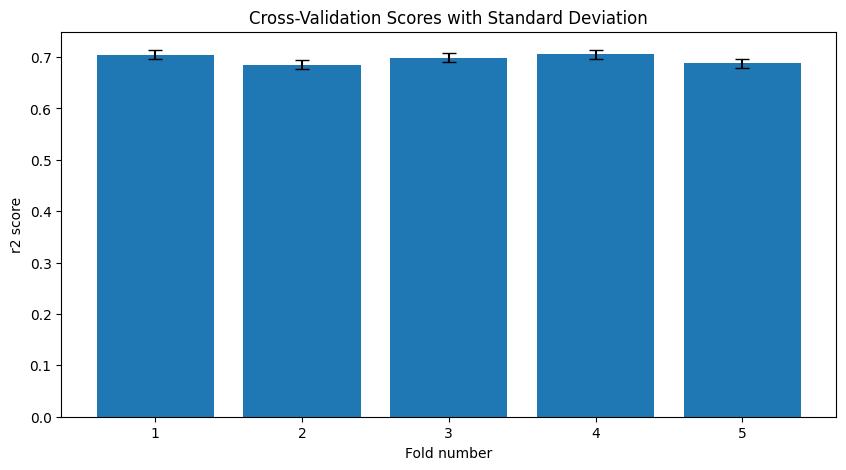

In [93]:
plot_crossval(cvs2)

### Target #3
This time, we will look at another target, which is quite different from the previous ones : the average delay of all trains on departure.

In [95]:
Y_retard_moy_depart = sncf_data["Retard moyen de tous les trains au départ"]
find_best_model(X,Y_retard_moy_depart)

Linear Regression : MSE =  25.35689573912456
Polynomial Regression : MSE =  53.68082100712735
Ridge Regression : MSE =  25.35689523505277
Lasso Regression : MSE =  25.3544309935985
Random Forest : MSE =  28.552389715497167
Gradient Boosting : MSE =  25.755154636783296


Mean Squared Error: 24.674861050210936
R-squared Score: 0.005729969880622021


[]

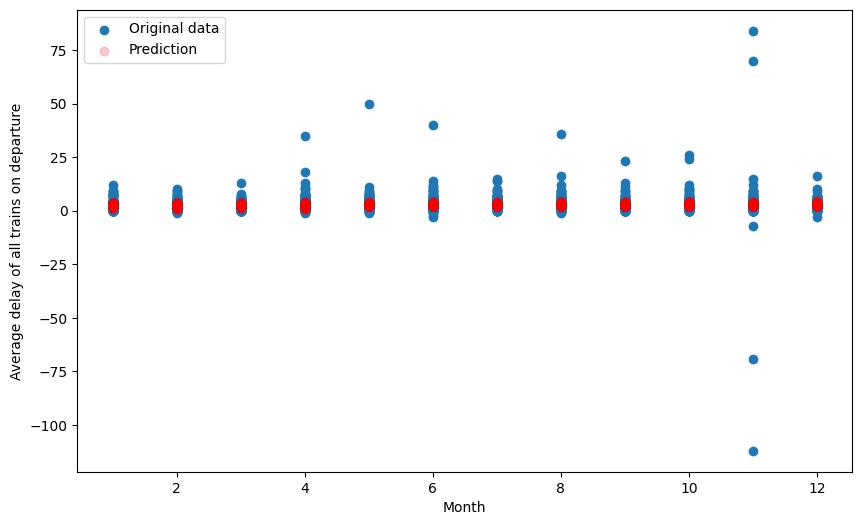

In [113]:
model3, X_train3, X_test3, y_train3, y_test3, y_pred3 = train_model("Ridge Regression",X,Y_retard_moy_depart)
plt.figure(figsize=(10, 6))
X_test3.iloc[:, 0] = X_test3.iloc[:, 0].astype(int)
y_test3 = y_test3.astype(int)
y_pred3 = y_pred3.astype(int)
plt.scatter(X_test3.iloc[:, 0], y_test3, label='Original data')
plt.scatter(X_test3.iloc[:, 0], y_pred3, color='red', alpha=.2,label='Prediction')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Average delay of all trains on departure")
plt.plot()

This graph describes really well the bad R²-score, but it is understandable : when we study the average delay of all trains on departure, we consider also all the trains that are NOT late, which is (hopefully) a huge majority in the dataset. That is why the model is really bad : on this target, even a little delay like 20-30 minutes is a value really unusual, and the model will hardly predict it. Also, we can maybe criticise a bit the model, as we can see some values are hugely negative, which is anormal : trains always start on time, or delayed, but never earlier. A longer time on the project could have helped us to search on different sources to find where these values could come from. We could only find that these values concerns a trip from Nîmes to Paris-Lyon and from Valence to Paris-Lyon.

Cross-Validation Scores (R²): [0.03641129 0.20742755 0.08272087 0.13997842 0.06820542]
Mean :  0.1069487112022706


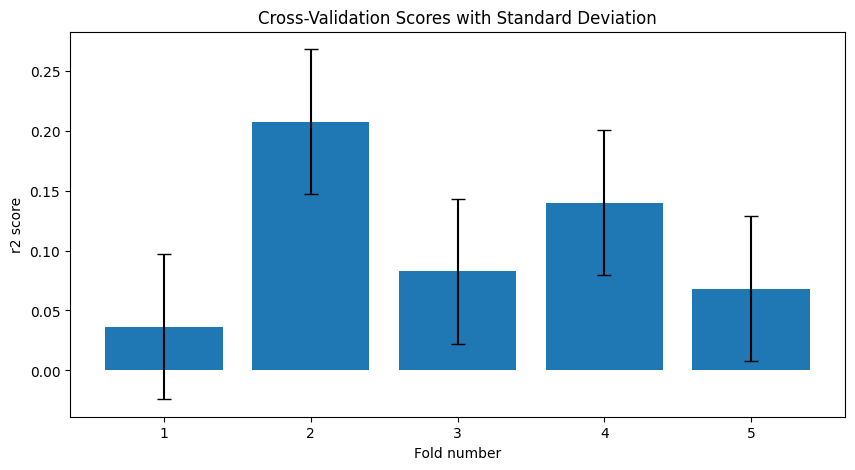

In [131]:
cvs3 = crossval(X_train3, y_train3)
plot_crossval(cvs3)

### Target #4

Finally, let's target another different value of the previous ones : the average delay of trains delayed on arrival.

In [132]:
Y_retard_moy_arrivee=sncf_data["Retard moyen des trains en retard à l'arrivée"]
find_best_model(X,Y_retard_moy_arrivee)

Linear Regression : MSE =  206.7252940612505
Polynomial Regression : MSE =  5903.978546105376
Ridge Regression : MSE =  206.72528779467916
Lasso Regression : MSE =  206.72403852030615
Random Forest : MSE =  217.69469018228818
Gradient Boosting : MSE =  189.00505143325847


Mean Squared Error: 196.75976722866972
R-squared Score: 0.2717307227023946


[]

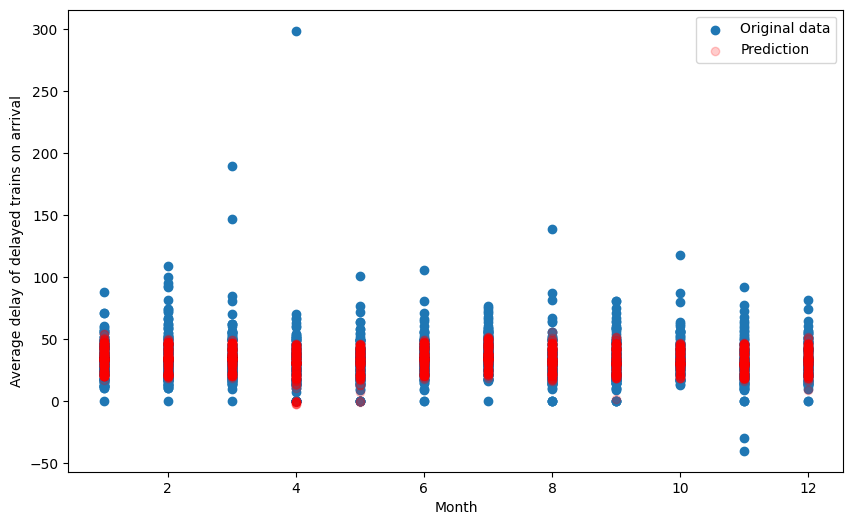

In [133]:
model4, X_train4, X_test4, y_train4, y_test4, y_pred4 = train_model("Gradient Boosting",X,Y_retard_moy_arrivee)
plt.figure(figsize=(10, 6))
X_test4.iloc[:, 0] = X_test4.iloc[:, 0].astype(int)
y_test4 = y_test4.astype(int)
y_pred4 = y_pred4.astype(int)
plt.scatter(X_test4.iloc[:, 0], y_test4, label='Original data')
plt.scatter(X_test4.iloc[:, 0], y_pred4, color='red', alpha=.2,label='Prediction')
plt.legend()
plt.xlabel("Month")
plt.ylabel("Average delay of delayed trains on arrival")
plt.plot()

Here again, some values are really anormal, but it is a bit more realistic than the last one : it is at least more possible that the average delay of delayed trains was multiple hours than average trains pulls out earlier. The model is okay, but as we can justify by the R²-score, it could be better.

Cross-Validation Scores (R²): [0.2497568  0.2623223  0.2576591  0.15349418 0.27217148]
Mean :  0.23908077176194653


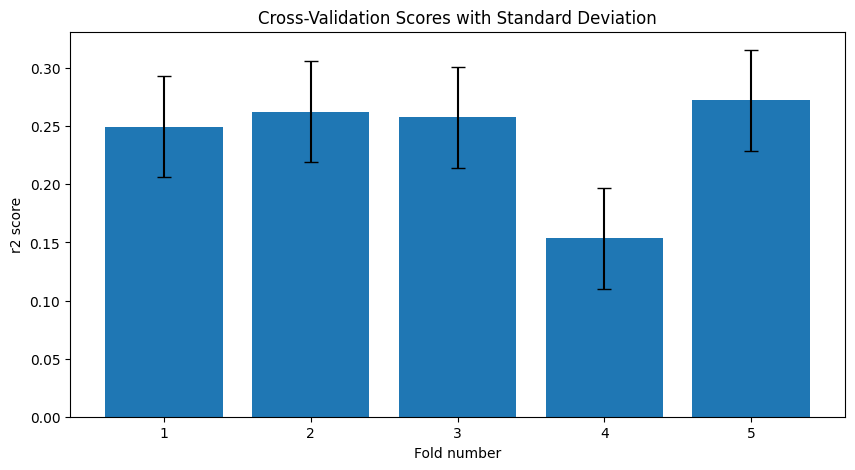

In [120]:
cvs4 = crossval(X_train4, y_train4)
plot_crossval(cvs4)

This conclude our Machine Learning group project. We hope you found it interesting and relevant.

Théo PROSPER, M2 Hadamard

Simon LEGRIS, M1 Mathématiques & Intelligence Artificielle

Félix OLLIVIER, M1 Mathématiques & Intelligence Artificielle